<a href="https://colab.research.google.com/github/morozova111/SQL-PYTHON/blob/main/%D0%B2%D0%BE%D1%80%D0%BE%D0%BD%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание:**    Для того чтобы отслеживать, как выглядит путь клиента от знакомства с продуктом до его получения, и какие в нем есть проблемные места, аналитики часто строят воронки. Этот инструмент позволяет понять, сколько клиентов "теряется" на каждом из этапов процесса и сколько в итоге совершает целевое действие.

Постройте воронку, которая показывала бы в динамике по неделям и месяцам, сколько клиентов посещает наш сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на нее. Количество клиентов и конверсии необходимо изобразить на одном графике.

Какие выводы можно сделать исходя из построенной воронки, какие точки роста продукта вы видите?


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from IPython.display import Image

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings("ignore")
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


# Загрузка данных и предобработка

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Тинькофф_аналитика/T-off_msu_analytics_game.csv' , delimiter=';')
df.head()

,game_rk,quest_rk,employee_rk,game_dttm,price,game_flg,finish_flg,time,application_rk,account_rk,...,client_rk,registration_dttm,login,password,email,client_rk.1,first_name,last_name,phone_num,visit_dttm
0,15,13,11,2022-11-17 02:13:10.970,2701.92,0,0,00:00:00,195,452,...,3419,2022-11-07 11:57:40.606,nazar32,dkKLBwPgI,nazar3237@example.com,3419,Алёна,Филатова,79089447542,2022-11-07 02:55:21.854
1,79,31,3,2022-12-02 19:53:58.107,1399.31,0,0,00:00:00,448,811,...,2201,2022-11-12 01:39:22.582,ignat.drozdova,zwoJvWBHr,ignat.drozdova52@example.com,2201,Майя,Хохлова,79639205888,2022-11-11 17:12:31.465
2,111,21,14,2022-11-22 09:31:30.506,1349.32,0,0,00:00:00,87,729,...,2662,2022-11-08 12:03:27.947,sava13,qLgZ502FD,sava1387@example.org,2662,Светлана,Савельева,79509647324,2022-11-07 15:59:56.006
3,127,15,7,2022-12-27 01:59:28.540,1557.79,0,0,00:00:00,445,626,...,1567,2022-12-07 00:47:33.593,nazarova.egor,qXinUeUKre2,nazarova.egor69@example.org,1567,Мария,Русакова,79664689794,2022-12-06 21:44:06.551
4,143,22,8,2022-12-30 10:39:51.834,1880.07,0,0,00:00:00,400,481,...,577,2022-10-17 03:19:49.432,wsilin,dvqgvlBUq,wsilin85@example.org,577,Искра,Шарова,79677283765,2022-10-16 13:29:49.080


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   game_rk            512 non-null    int64  
 1   quest_rk           512 non-null    int64  
 2   employee_rk        512 non-null    int64  
 3   game_dttm          512 non-null    object 
 4   price              512 non-null    float64
 5   game_flg           512 non-null    int64  
 6   finish_flg         512 non-null    int64  
 7   time               512 non-null    object 
 8   application_rk     512 non-null    int64  
 9   account_rk         512 non-null    int64  
 10  game_rk.1          512 non-null    int64  
 11  application_dttm   512 non-null    object 
 12  account_rk.1       512 non-null    int64  
 13  client_rk          512 non-null    int64  
 14  registration_dttm  512 non-null    object 
 15  login              512 non-null    object 
 16  password           512 non

Из исходного датасета необходимо сформировать рабочий датасет для решения текущей задачи.

Группироем датасет по интересующим колонкам времени:
 1. visit_dttm - дата визита
 2. registration_dttm - регистрация клиента на сайте
 3. application_dttm - заявка на игру клиента
 4. game_dttm - запланированного начала игры
 5. price - цена
 6. game_flg - флаг проведения игры
 7. finish_flg - флаг окончания игры
 8. client_rk - карточка клиента


In [ ]:
data = df.copy(deep=True)
data

,game_rk,quest_rk,employee_rk,game_dttm,price,game_flg,finish_flg,time,application_rk,account_rk,...,client_rk,registration_dttm,login,password,email,client_rk.1,first_name,last_name,phone_num,visit_dttm
0,15,13,11,2022-11-17 02:13:10.970,2701.92,0,0,00:00:00,195,452,...,3419,2022-11-07 11:57:40.606,nazar32,dkKLBwPgI,nazar3237@example.com,3419,Алёна,Филатова,79089447542,2022-11-07 02:55:21.854
1,79,31,3,2022-12-02 19:53:58.107,1399.31,0,0,00:00:00,448,811,...,2201,2022-11-12 01:39:22.582,ignat.drozdova,zwoJvWBHr,ignat.drozdova52@example.com,2201,Майя,Хохлова,79639205888,2022-11-11 17:12:31.465
2,111,21,14,2022-11-22 09:31:30.506,1349.32,0,0,00:00:00,87,729,...,2662,2022-11-08 12:03:27.947,sava13,qLgZ502FD,sava1387@example.org,2662,Светлана,Савельева,79509647324,2022-11-07 15:59:56.006
3,127,15,7,2022-12-27 01:59:28.540,1557.79,0,0,00:00:00,445,626,...,1567,2022-12-07 00:47:33.593,nazarova.egor,qXinUeUKre2,nazarova.egor69@example.org,1567,Мария,Русакова,79664689794,2022-12-06 21:44:06.551
4,143,22,8,2022-12-30 10:39:51.834,1880.07,0,0,00:00:00,400,481,...,577,2022-10-17 03:19:49.432,wsilin,dvqgvlBUq,wsilin85@example.org,577,Искра,Шарова,79677283765,2022-10-16 13:29:49.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,329,29,8,2023-02-25 18:59:02.986,2668.38,0,0,00:00:00,428,761,...,1049,2022-10-27 15:32:50.964,epetrov,JdR6R1hV,epetrov41@example.com,1049,Жанна,Панова,79673025144,2022-10-27 05:32:05.872
508,329,29,8,2023-02-25 18:59:02.986,2668.38,0,0,00:00:00,53,659,...,2623,2022-09-16 02:37:57.369,avgust.subbotina,BC1A5GINW,avgust.subbotina26@example.net,2623,Регина,Филиппова,79515741226,2022-09-15 15:39:25.219
509,329,29,8,2023-02-25 18:59:02.986,2668.38,0,0,00:00:00,44,565,...,928,2022-12-19 18:40:17.517,wnikitina,Jk0s67nUWb7D,wnikitina90@example.net,928,Олег,Давыдов,79674141109,2022-12-19 12:42:40.286
510,329,29,8,2023-02-25 18:59:02.986,2668.38,0,0,00:00:00,111,657,...,2654,2022-10-29 07:45:28.693,ekaterina.terenteva,3EnZBlv1Mb,ekaterina.terenteva80@example.net,2654,Роман,Туров,79521279961,2022-10-28 20:51:04.017


Колонку со временем игры не беру, т.к. в ней 264 заполненных значения против 248 пустых.

In [ ]:
df2 = data.loc[:,['client_rk','game_flg','finish_flg','visit_dttm' , 'registration_dttm', 'application_dttm' ,'game_dttm']]
df2.head(10)

,client_rk,game_flg,finish_flg,visit_dttm,registration_dttm,application_dttm,game_dttm
0,3419,0,0,2022-11-07 02:55:21.854,2022-11-07 11:57:40.606,2022-11-13 14:19:14.332,2022-11-17 02:13:10.970
1,2201,0,0,2022-11-11 17:12:31.465,2022-11-12 01:39:22.582,2022-11-25 04:34:43.487,2022-12-02 19:53:58.107
2,2662,0,0,2022-11-07 15:59:56.006,2022-11-08 12:03:27.947,2022-11-22 00:49:28.544,2022-11-22 09:31:30.506
3,1567,0,0,2022-12-06 21:44:06.551,2022-12-07 00:47:33.593,2022-12-19 22:23:05.226,2022-12-27 01:59:28.540
4,577,0,0,2022-10-16 13:29:49.080,2022-10-17 03:19:49.432,2022-10-28 14:32:39.774,2022-12-30 10:39:51.834
5,1435,0,0,2022-11-21 10:37:25.643,2022-11-22 06:37:34.022,2022-12-02 08:50:54.100,2022-12-30 10:39:51.834
6,2316,0,0,2022-12-12 22:07:58.542,2022-12-13 03:33:52.640,2022-12-22 22:38:18.735,2023-01-26 06:21:12.521
7,2201,0,0,2022-11-11 17:12:31.465,2022-11-12 01:39:22.582,2022-11-24 20:27:45.347,2023-01-28 22:58:44.244
8,2405,0,0,2023-01-01 00:27:29.930,2023-01-01 05:32:34.898,2023-01-06 22:56:16.179,2023-01-28 22:58:44.244
9,3726,0,0,2022-09-14 20:09:14.320,2022-09-15 01:13:02.758,2022-09-23 23:12:43.674,2023-01-18 05:11:23.051


In [ ]:
df2.sort_values(by='client_rk', inplace = True)
df2.tail()

,client_rk,game_flg,finish_flg,visit_dttm,registration_dttm,application_dttm,game_dttm
295,4067,0,0,2023-01-11 10:18:06.999,2023-01-11 20:53:43.389,2023-01-22 18:15:39.020,2023-03-17 19:06:07.633
255,4067,0,0,2023-01-11 10:18:06.999,2023-01-11 20:53:43.389,2023-01-13 17:29:26.992,2023-02-20 12:12:55.189
486,4079,1,0,2022-12-12 02:58:06.922,2022-12-13 00:00:55.109,2022-12-24 07:46:14.545,2023-01-20 04:32:33.395
105,4093,1,1,2022-09-28 10:52:20.013,2022-09-29 08:14:01.473,2022-10-06 02:29:59.932,2023-01-31 21:32:33.150
424,4093,1,1,2022-09-28 10:52:20.013,2022-09-29 08:14:01.473,2022-10-08 03:59:42.419,2023-01-14 09:38:28.817


In [ ]:
df2.sort_values(by='visit_dttm', inplace = True)
df2.tail()

,client_rk,game_flg,finish_flg,visit_dttm,registration_dttm,application_dttm,game_dttm
511,1953,0,0,2023-01-30 19:34:08.712,2023-01-31 05:04:54.261,2023-01-31 17:47:41.584,2023-02-25 18:59:02.986
226,1953,0,0,2023-01-30 19:34:08.712,2023-01-31 05:04:54.261,2023-01-31 14:26:07.965,2023-02-11 07:30:07.204
331,3042,0,0,2023-01-31 09:32:47.523,2023-01-31 23:56:00.637,2023-02-01 19:25:10.112,2023-02-22 07:14:06.845
54,3499,0,0,2023-01-31 14:11:42.737,2023-01-31 19:06:02.463,2023-02-01 10:16:05.124,2023-02-06 19:37:27.776
305,2000,0,0,2023-01-31 18:13:28.572,2023-02-01 05:16:48.088,2023-02-01 13:41:28.461,2023-02-20 18:33:13.251


Стало видно, что некоторые пользователи заведены в БД несколько раз. Для каждого события по пользователю его ключ копировался и создавалась новая запись. Удалять дубликаты на этой стадии не имеет смысла, т.к. удалятся и нужные данные.

In [ ]:
df2.duplicated()

154    False
16     False
381    False
171    False
326    False
       ...  
511    False
226    False
331    False
54     False
305    False
Length: 512, dtype: bool

In [ ]:
len(df2)- len(df2.drop_duplicates ())

0

Хорошая новость! У нас нет дубликатов.

  Не совсем понятно, нужно ли брать в расчёт тех участников, кто дошел до конца игры или воронка должна заканчиваться датой подачи заявки и началом игры.

   Игра может как состояться, так и не состояться. Плюс количество участников дошедших до конца квеста составляет 133 человека и 131 участник не дошёл до конца.

Убираю время события из столбцов с датами, т.к. нет информации по привязке к часовому поясу. Сразу же преобразовала эти столбцы в строку для дальнейшего перевода в datetime.

# Разбиваю по столбцам - событиям для удаления дубликатов и установки флагов

In [ ]:
df3 = df2.loc[:,['client_rk','visit_dttm']]
df3.head()

,client_rk,visit_dttm
154,1748,2022-09-01 07:51:05.295
16,1748,2022-09-01 07:51:05.295
381,3664,2022-09-03 18:01:07.839
171,1143,2022-09-04 13:07:01.356
326,1003,2022-09-04 13:38:44.973


In [ ]:
df3['step1'] = "visit"

In [ ]:
df3.drop_duplicates(subset=['client_rk','visit_dttm'], keep = 'first', inplace = True)

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 154 to 305
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   client_rk   293 non-null    int64 
 1   visit_dttm  293 non-null    object
 2   step1       293 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.2+ KB


В столбце регистрации остаются записи только тех участников, кто уже хоть раз бывал на сайте. Следовательно, участники с одной записью сюда не попадают.


Также на регистрации остаются участники имеющие две записи и вторая должна быть больше по времени, чем первая.

In [ ]:
df4 = df2.loc[:,['client_rk','visit_dttm','registration_dttm']]
df4.head()

,client_rk,visit_dttm,registration_dttm
154,1748,2022-09-01 07:51:05.295,2022-09-02 06:42:31.922
16,1748,2022-09-01 07:51:05.295,2022-09-02 06:42:31.922
381,3664,2022-09-03 18:01:07.839,2022-09-04 07:46:06.120
171,1143,2022-09-04 13:07:01.356,2022-09-05 01:37:34.424
326,1003,2022-09-04 13:38:44.973,2022-09-05 11:23:44.405


In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 154 to 305
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   client_rk          512 non-null    int64 
 1   visit_dttm         512 non-null    object
 2   registration_dttm  512 non-null    object
dtypes: int64(1), object(2)
memory usage: 16.0+ KB


In [ ]:
df4.sort_values(by=['client_rk','registration_dttm'], inplace = True)
df4.tail(10)

,client_rk,visit_dttm,registration_dttm
410,3971,2022-11-18 19:28:39.623,2022-11-19 16:53:46.096
355,3971,2022-11-18 19:28:39.623,2022-11-19 16:53:46.096
483,4025,2022-12-03 14:52:22.744,2022-12-04 09:38:22.481
239,4037,2022-09-28 20:52:10.278,2022-09-29 13:36:39.940
295,4067,2023-01-11 10:18:06.999,2023-01-11 20:53:43.389
307,4067,2023-01-11 10:18:06.999,2023-01-11 20:53:43.389
255,4067,2023-01-11 10:18:06.999,2023-01-11 20:53:43.389
486,4079,2022-12-12 02:58:06.922,2022-12-13 00:00:55.109
105,4093,2022-09-28 10:52:20.013,2022-09-29 08:14:01.473
424,4093,2022-09-28 10:52:20.013,2022-09-29 08:14:01.473


In [ ]:
df4=df4[df4.groupby('client_rk')['client_rk'].transform('size') > 1]

In [ ]:
df4.head()

,client_rk,visit_dttm,registration_dttm
431,4,2022-11-30 04:44:11.949,2022-12-01 00:58:56.483
342,4,2022-11-30 04:44:11.949,2022-12-01 00:58:56.483
205,25,2022-11-09 04:33:41.121,2022-11-10 04:05:18.819
308,25,2022-11-09 04:33:41.121,2022-11-10 04:05:18.819
14,35,2023-01-07 21:51:34.847,2023-01-08 14:49:10.008


In [ ]:
df4['step2'] = "reg"

In [ ]:
df4 = df4.drop_duplicates(subset=['client_rk','registration_dttm'], keep = 'first')

In [ ]:
df4 = df4.drop('visit_dttm', axis=1)

In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 431 to 105
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   client_rk          160 non-null    int64 
 1   registration_dttm  160 non-null    object
 2   step2              160 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.0+ KB


In [ ]:
df4.tail()

,client_rk,registration_dttm,step2
434,3937,2022-12-30 17:56:07.053,reg
412,3970,2022-09-05 18:40:29.716,reg
410,3971,2022-11-19 16:53:46.096,reg
295,4067,2023-01-11 20:53:43.389,reg
105,4093,2022-09-29 08:14:01.473,reg


В столбце с заявкой на принятие участия в квесте должны остаться только те участники, которые прошли два предыдущих этапа.

Если от одного участника поступило несколько заявок, учитываем самую раннюю.

In [ ]:
df5 = df2.loc[:,['client_rk','application_dttm']]


In [ ]:
df5.sort_values(by=['client_rk','application_dttm'], inplace = True)
df5.tail(10)

,client_rk,application_dttm
355,3971,2022-11-24 09:14:17.525
410,3971,2022-11-26 09:59:43.190
483,4025,2022-12-13 01:56:20.547
239,4037,2022-09-30 02:15:46.377
307,4067,2023-01-13 08:08:40.077
255,4067,2023-01-13 17:29:26.992
295,4067,2023-01-22 18:15:39.020
486,4079,2022-12-24 07:46:14.545
105,4093,2022-10-06 02:29:59.932
424,4093,2022-10-08 03:59:42.419


In [ ]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 342 to 424
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_rk         512 non-null    int64 
 1   application_dttm  512 non-null    object
dtypes: int64(1), object(1)
memory usage: 12.0+ KB


In [ ]:
df5['step3'] = "app"

In [ ]:
df5=df5[df5.groupby('client_rk')['client_rk'].transform('size') > 2]

In [ ]:
df5.tail(10)

,client_rk,application_dttm,step3
235,3713,2023-01-22 16:12:12.558,app
174,3827,2023-01-28 01:15:13.853,app
474,3827,2023-01-28 05:05:55.099,app
181,3827,2023-01-28 06:05:23.710,app
91,3833,2022-12-14 08:16:32.672,app
328,3833,2022-12-14 19:37:19.566,app
115,3833,2022-12-24 10:04:17.857,app
307,4067,2023-01-13 08:08:40.077,app
255,4067,2023-01-13 17:29:26.992,app
295,4067,2023-01-22 18:15:39.020,app


In [ ]:
df5.drop_duplicates(subset=['client_rk'], keep = 'first', inplace = True)

In [ ]:
df5.head(10)

,client_rk,application_dttm,step3
232,70,2023-01-12 14:46:23.032,app
498,153,2022-10-04 16:43:35.416,app
319,227,2022-12-06 13:54:20.824,app
468,461,2022-10-06 10:44:50.700,app
494,541,2022-11-03 02:11:53.423,app
357,583,2022-09-18 06:20:46.188,app
250,685,2023-01-26 21:22:56.512,app
49,834,2022-11-06 18:15:00.644,app
203,841,2023-01-15 19:58:04.137,app
243,851,2022-10-04 20:35:12.447,app


In [ ]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 232 to 307
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_rk         53 non-null     int64 
 1   application_dttm  53 non-null     object
 2   step3             53 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.7+ KB


C приходом на игру возникают сложности, потому как в столбце dame_dttm указано время запланированной игры, а не фактической.
Фактическое участие отмечено в столбце game_flg.
Благодаря размеру датасета видно участников, игравших более одного раза и участников пропустивших игры.

In [ ]:
df6=df2[df2.groupby('client_rk')['client_rk'].transform('size') > 3]

In [ ]:
df6.sort_values(by=['client_rk','game_dttm','game_flg'], inplace = True)
df6.head(30)

,client_rk,game_flg,finish_flg,visit_dttm,registration_dttm,application_dttm,game_dttm
168,1015,1,1,2022-11-11 01:26:46.574,2022-11-11 12:17:26.232,2022-11-17 11:03:24.416,2023-01-14 07:09:11.006
179,1015,0,0,2022-11-11 01:26:46.574,2022-11-11 12:17:26.232,2022-11-13 19:50:47.969,2023-02-03 16:03:52.254
368,1015,0,0,2022-11-11 01:26:46.574,2022-11-11 12:17:26.232,2022-11-25 06:35:35.535,2023-02-03 16:23:27.883
93,1015,0,0,2022-11-11 01:26:46.574,2022-11-11 12:17:26.232,2022-11-23 07:33:32.365,2023-03-15 00:22:25.115
47,1785,0,0,2022-11-04 08:41:35.130,2022-11-05 02:52:44.836,2022-11-18 17:39:37.152,2022-12-13 13:17:28.688
457,1785,1,1,2022-11-04 08:41:35.130,2022-11-05 02:52:44.836,2022-11-10 11:29:28.559,2022-12-26 17:55:03.839
157,1785,1,1,2022-11-04 08:41:35.130,2022-11-05 02:52:44.836,2022-11-18 21:58:39.670,2023-01-09 09:21:41.080
11,1785,0,0,2022-11-04 08:41:35.130,2022-11-05 02:52:44.836,2022-11-16 23:03:36.719,2023-01-18 05:11:23.051
141,2662,1,0,2022-11-07 15:59:56.006,2022-11-08 12:03:27.947,2022-11-19 22:38:58.121,2022-11-20 11:16:02.502
2,2662,0,0,2022-11-07 15:59:56.006,2022-11-08 12:03:27.947,2022-11-22 00:49:28.544,2022-11-22 09:31:30.506


In [ ]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 168 to 301
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   client_rk          24 non-null     int64 
 1   game_flg           24 non-null     int64 
 2   finish_flg         24 non-null     int64 
 3   visit_dttm         24 non-null     object
 4   registration_dttm  24 non-null     object
 5   application_dttm   24 non-null     object
 6   game_dttm          24 non-null     object
dtypes: int64(3), object(4)
memory usage: 1.5+ KB


In [ ]:
df6['step4'] = "game"

In [ ]:
df6.drop_duplicates(subset=['client_rk','game_flg'], inplace = True)

In [ ]:
df6= df6[df6.game_flg !=0]

In [ ]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 168 to 276
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   client_rk          5 non-null      int64 
 1   game_flg           5 non-null      int64 
 2   finish_flg         5 non-null      int64 
 3   visit_dttm         5 non-null      object
 4   registration_dttm  5 non-null      object
 5   application_dttm   5 non-null      object
 6   game_dttm          5 non-null      object
 7   step4              5 non-null      object
dtypes: int64(3), object(5)
memory usage: 360.0+ bytes


In [ ]:
df6.head(13)

,client_rk,game_flg,finish_flg,visit_dttm,registration_dttm,application_dttm,game_dttm,step4
168,1015,1,1,2022-11-11 01:26:46.574,2022-11-11 12:17:26.232,2022-11-17 11:03:24.416,2023-01-14 07:09:11.006,game
457,1785,1,1,2022-11-04 08:41:35.130,2022-11-05 02:52:44.836,2022-11-10 11:29:28.559,2022-12-26 17:55:03.839,game
141,2662,1,0,2022-11-07 15:59:56.006,2022-11-08 12:03:27.947,2022-11-19 22:38:58.121,2022-11-20 11:16:02.502,game
409,3135,1,0,2022-09-23 06:50:30.529,2022-09-23 14:13:52.322,2022-10-03 02:20:46.308,2022-11-01 03:58:06.214,game
276,3711,1,0,2022-10-22 20:37:15.929,2022-10-22 22:48:14.678,2022-10-28 12:07:58.441,2022-12-07 04:54:57.130,game


In [ ]:
df6 = df6.drop(['visit_dttm', 'registration_dttm', 'application_dttm'] , axis=1)

**Расчёты готовы. Объединяю полученные датафреймы в итоговый.**

In [ ]:
res=df3.merge(df4, left_on='client_rk', right_on ='client_rk', how='left' )

In [ ]:
res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   client_rk          293 non-null    int64 
 1   visit_dttm         293 non-null    object
 2   step1              293 non-null    object
 3   registration_dttm  160 non-null    object
 4   step2              160 non-null    object
dtypes: int64(1), object(4)
memory usage: 13.7+ KB


In [ ]:
resu=res.merge(df5, left_on='client_rk', right_on ='client_rk', how='left')

In [ ]:
resu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 292
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   client_rk          293 non-null    int64 
 1   visit_dttm         293 non-null    object
 2   step1              293 non-null    object
 3   registration_dttm  160 non-null    object
 4   step2              160 non-null    object
 5   application_dttm   53 non-null     object
 6   step3              53 non-null     object
dtypes: int64(1), object(6)
memory usage: 18.3+ KB


In [ ]:
result=resu.merge(df6, left_on='client_rk', right_on ='client_rk', how='left')

In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 292
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_rk          293 non-null    int64  
 1   visit_dttm         293 non-null    object 
 2   step1              293 non-null    object 
 3   registration_dttm  160 non-null    object 
 4   step2              160 non-null    object 
 5   application_dttm   53 non-null     object 
 6   step3              53 non-null     object 
 7   game_flg           5 non-null      float64
 8   finish_flg         5 non-null      float64
 9   game_dttm          5 non-null      object 
 10  step4              5 non-null      object 
dtypes: float64(2), int64(1), object(8)
memory usage: 27.5+ KB


# Месяца - недели

In [ ]:
size = result.copy(deep=True)
size.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 292
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_rk          293 non-null    int64  
 1   visit_dttm         293 non-null    object 
 2   step1              293 non-null    object 
 3   registration_dttm  160 non-null    object 
 4   step2              160 non-null    object 
 5   application_dttm   53 non-null     object 
 6   step3              53 non-null     object 
 7   game_flg           5 non-null      float64
 8   finish_flg         5 non-null      float64
 9   game_dttm          5 non-null      object 
 10  step4              5 non-null      object 
dtypes: float64(2), int64(1), object(8)
memory usage: 27.5+ KB


In [ ]:
size[['visit_dttm', 'registration_dttm','application_dttm', 'game_dttm']] = size[['visit_dttm', 'registration_dttm','application_dttm', 'game_dttm']].astype(str).applymap(lambda x: x[:10])


In [ ]:
size.dtypes.value_counts()

object     8
float64    2
int64      1
dtype: int64

In [ ]:
import datetime

In [ ]:
from datetime import datetime

In [ ]:
size['Visit_M'] = pd.to_datetime(size['visit_dttm'], format ='%Y-%m', errors='coerce')
size['Reg_M'] =  pd.to_datetime(size['registration_dttm'], format ='%Y-%m', errors='coerce')
size['App_M']= pd.to_datetime(size['application_dttm'], format ='%Y-%m', errors='coerce')
size['Game_M'] =  pd.to_datetime(size['game_dttm'], format ='%Y-%m', errors='coerce')

In [ ]:
size['visit_dttm'] = pd.to_datetime(size['visit_dttm'])
size['registration_dttm'] = pd.to_datetime(size['registration_dttm'])
size['application_dttm'] = pd.to_datetime(size['application_dttm'])
size['game_dttm'] = pd.to_datetime(size['game_dttm'])

In [ ]:
size[['Visit_M', 'Reg_M','App_M', 'Game_M']] = size[['Visit_M', 'Reg_M','App_M', 'Game_M']].astype(str).applymap(lambda x: x[:7])


In [ ]:
size['Visit_Y'] = size['visit_dttm'].dt.year
size['Reg_Y'] = size['registration_dttm'].dt.year
size['App_Y'] = size['application_dttm'].dt.year
size['Game_Y'] = size['game_dttm'].dt.year

In [ ]:
size[['Visit_Y', 'Reg_Y','App_Y', 'Game_Y']] = size[['Visit_Y', 'Reg_Y','App_Y', 'Game_Y']].astype(str).applymap(lambda x: x[:4])


In [ ]:
size.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 292
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   client_rk          293 non-null    int64         
 1   visit_dttm         293 non-null    datetime64[ns]
 2   step1              293 non-null    object        
 3   registration_dttm  160 non-null    datetime64[ns]
 4   step2              160 non-null    object        
 5   application_dttm   53 non-null     datetime64[ns]
 6   step3              53 non-null     object        
 7   game_flg           5 non-null      float64       
 8   finish_flg         5 non-null      float64       
 9   game_dttm          5 non-null      datetime64[ns]
 10  step4              5 non-null      object        
 11  Visit_M            293 non-null    object        
 12  Reg_M              293 non-null    object        
 13  App_M              293 non-null    object        
 14  Game_M    

In [ ]:

size.head()


,client_rk,visit_dttm,step1,registration_dttm,step2,application_dttm,step3,game_flg,finish_flg,game_dttm,step4,Visit_M,Reg_M,App_M,Game_M,Visit_Y,Reg_Y,App_Y,Game_Y
0,1748,2022-09-01,visit,2022-09-02,reg,NaT,NaN,NaN,NaN,NaT,NaN,2022-09,2022-09,NaT,NaT,2022,2022,nan,nan
1,3664,2022-09-03,visit,NaT,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2022-09,NaT,NaT,NaT,2022,nan,nan,nan
2,1143,2022-09-04,visit,NaT,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2022-09,NaT,NaT,NaT,2022,nan,nan,nan
3,1003,2022-09-04,visit,2022-09-05,reg,2022-09-07,app,NaN,NaN,NaT,NaN,2022-09,2022-09,2022-09,NaT,2022,2022,2022,nan
4,2735,2022-09-04,visit,2022-09-05,reg,2022-09-06,app,NaN,NaN,NaT,NaN,2022-09,2022-09,2022-09,NaT,2022,2022,2022,nan


Выделяю недели из датасета

In [ ]:
size['Visit_We'] = size['visit_dttm'].dt.isocalendar().week
size['Reg_We'] = size['registration_dttm'].dt.isocalendar().week
size['App_We'] = size['application_dttm'].dt.isocalendar().week
size['Game_We'] = size['game_dttm'].dt.isocalendar().week


И здесь появляется ошибка: 23-01-01 считается как 52 неделя.

In [ ]:
size['Visit_W'] =size['Visit_Y'].astype(str) + "-" + size['Visit_We'].astype(str)
size['Reg_W'] =size['Reg_Y'].astype(str) + "-" + size['Reg_We'].astype(str)
size['App_W'] =size['App_Y'].astype(str) + "-" + size['App_We'].astype(str)
size['Game_W'] =size['Game_Y'].astype(str) + "-" + size['Game_We'].astype(str)
size.head()

,client_rk,visit_dttm,step1,registration_dttm,step2,application_dttm,step3,game_flg,finish_flg,game_dttm,...,App_Y,Game_Y,Visit_We,Reg_We,App_We,Game_We,Visit_W,Reg_W,App_W,Game_W
0,1748,2022-09-01,visit,2022-09-02,reg,NaT,NaN,NaN,NaN,NaT,...,nan,nan,35,35,<NA>,<NA>,2022-35,2022-35,nan-<NA>,nan-<NA>
1,3664,2022-09-03,visit,NaT,NaN,NaT,NaN,NaN,NaN,NaT,...,nan,nan,35,<NA>,<NA>,<NA>,2022-35,nan-<NA>,nan-<NA>,nan-<NA>
2,1143,2022-09-04,visit,NaT,NaN,NaT,NaN,NaN,NaN,NaT,...,nan,nan,35,<NA>,<NA>,<NA>,2022-35,nan-<NA>,nan-<NA>,nan-<NA>
3,1003,2022-09-04,visit,2022-09-05,reg,2022-09-07,app,NaN,NaN,NaT,...,2022,nan,35,36,36,<NA>,2022-35,2022-36,2022-36,nan-<NA>
4,2735,2022-09-04,visit,2022-09-05,reg,2022-09-06,app,NaN,NaN,NaT,...,2022,nan,35,36,36,<NA>,2022-35,2022-36,2022-36,nan-<NA>


Удаляю столбцы с промежуточными результатами.

In [ ]:
size.drop(columns=['Visit_We', 'Visit_Y', 'Reg_Y','Reg_We','App_We', 'App_Y','Game_Y', 'Game_We'],inplace=True)
size.head()

,client_rk,visit_dttm,step1,registration_dttm,step2,application_dttm,step3,game_flg,finish_flg,game_dttm,step4,Visit_M,Reg_M,App_M,Game_M,Visit_W,Reg_W,App_W,Game_W
0,1748,2022-09-01,visit,2022-09-02,reg,NaT,NaN,NaN,NaN,NaT,NaN,2022-09,2022-09,NaT,NaT,2022-35,2022-35,nan-<NA>,nan-<NA>
1,3664,2022-09-03,visit,NaT,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2022-09,NaT,NaT,NaT,2022-35,nan-<NA>,nan-<NA>,nan-<NA>
2,1143,2022-09-04,visit,NaT,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2022-09,NaT,NaT,NaT,2022-35,nan-<NA>,nan-<NA>,nan-<NA>
3,1003,2022-09-04,visit,2022-09-05,reg,2022-09-07,app,NaN,NaN,NaT,NaN,2022-09,2022-09,2022-09,NaT,2022-35,2022-36,2022-36,nan-<NA>
4,2735,2022-09-04,visit,2022-09-05,reg,2022-09-06,app,NaN,NaN,NaT,NaN,2022-09,2022-09,2022-09,NaT,2022-35,2022-36,2022-36,nan-<NA>


In [ ]:
size["Visit_W"].replace(["2023-52"], "2023-1", inplace=True)
size["Reg_W"].replace(["2023-52"], "2023-1", inplace=True)
size["App_W"].replace(["2023-52"], "2023-1", inplace=True)
size["Game_W"].replace(["2023-52"], "2023-1", inplace=True)
size.head()

,client_rk,visit_dttm,step1,registration_dttm,step2,application_dttm,step3,game_flg,finish_flg,game_dttm,step4,Visit_M,Reg_M,App_M,Game_M,Visit_W,Reg_W,App_W,Game_W
0,1748,2022-09-01,visit,2022-09-02,reg,NaT,NaN,NaN,NaN,NaT,NaN,2022-09,2022-09,NaT,NaT,2022-35,2022-35,nan-<NA>,nan-<NA>
1,3664,2022-09-03,visit,NaT,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2022-09,NaT,NaT,NaT,2022-35,nan-<NA>,nan-<NA>,nan-<NA>
2,1143,2022-09-04,visit,NaT,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2022-09,NaT,NaT,NaT,2022-35,nan-<NA>,nan-<NA>,nan-<NA>
3,1003,2022-09-04,visit,2022-09-05,reg,2022-09-07,app,NaN,NaN,NaT,NaN,2022-09,2022-09,2022-09,NaT,2022-35,2022-36,2022-36,nan-<NA>
4,2735,2022-09-04,visit,2022-09-05,reg,2022-09-06,app,NaN,NaN,NaT,NaN,2022-09,2022-09,2022-09,NaT,2022-35,2022-36,2022-36,nan-<NA>


In [ ]:
size["Visit_W"].replace(["nan-<NA>"], "0", inplace=True)
size["Reg_W"].replace(["nan-<NA>"], "0", inplace=True)
size["App_W"].replace(["nan-<NA>"], "0", inplace=True)
size["Game_W"].replace(["nan-<NA>"], "0", inplace=True)


In [ ]:
size.head()

,client_rk,visit_dttm,step1,registration_dttm,step2,application_dttm,step3,game_flg,finish_flg,game_dttm,step4,Visit_M,Reg_M,App_M,Game_M,Visit_W,Reg_W,App_W,Game_W
0,1748,2022-09-01,visit,2022-09-02,reg,NaT,NaN,NaN,NaN,NaT,NaN,2022-09,2022-09,NaT,NaT,2022-35,2022-35,0,0
1,3664,2022-09-03,visit,NaT,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2022-09,NaT,NaT,NaT,2022-35,0,0,0
2,1143,2022-09-04,visit,NaT,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2022-09,NaT,NaT,NaT,2022-35,0,0,0
3,1003,2022-09-04,visit,2022-09-05,reg,2022-09-07,app,NaN,NaN,NaT,NaN,2022-09,2022-09,2022-09,NaT,2022-35,2022-36,2022-36,0
4,2735,2022-09-04,visit,2022-09-05,reg,2022-09-06,app,NaN,NaN,NaT,NaN,2022-09,2022-09,2022-09,NaT,2022-35,2022-36,2022-36,0


In [ ]:
step = size.copy(deep = True)
step.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 292
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   client_rk          293 non-null    int64         
 1   visit_dttm         293 non-null    datetime64[ns]
 2   step1              293 non-null    object        
 3   registration_dttm  160 non-null    datetime64[ns]
 4   step2              160 non-null    object        
 5   application_dttm   53 non-null     datetime64[ns]
 6   step3              53 non-null     object        
 7   game_flg           5 non-null      float64       
 8   finish_flg         5 non-null      float64       
 9   game_dttm          5 non-null      datetime64[ns]
 10  step4              5 non-null      object        
 11  Visit_M            293 non-null    object        
 12  Reg_M              293 non-null    object        
 13  App_M              293 non-null    object        
 14  Game_M    

In [ ]:
from plotly import graph_objects as go

In [ ]:
fig = go.Figure(go.Funnel(
    y = ["visit", "registration", "application", "game"],
    x = [293, 160, 53 , 5],
    textposition = "inside",
    textinfo = "value+percent initial",
    marker = {"color": ["azure","lightgreen", 'lightslategrey', 'lightseagreen', 'cadetblue']}
    ))
fig.show()

Воронка активности участников квеста строится на основе 293 наблюдений.
Количество участников к моменту регистрации снизилось на 45 процентных пунктов и составило 160 человек. До заявки на участие дошли 53 участника и в игре участвовало 5 человек.

Есть люди, проходившие квест дважды.

Также есть участники(4), которые несколько раз подавали заявки на участие.

**Динамика по месяцам**

In [ ]:
step_st1M = step.groupby('Visit_M')['step1'].value_counts()
step_st1M

Visit_M  step1
2022-09  visit    51
2022-10  visit    65
2022-11  visit    56
2022-12  visit    57
2023-01  visit    64
Name: step1, dtype: int64

In [ ]:
step_st3M = step.groupby('Reg_M')['step2'].value_counts()

step_st3M

Reg_M    step2
2022-09  reg      28
2022-10  reg      31
2022-11  reg      29
2022-12  reg      36
2023-01  reg      36
Name: step2, dtype: int64

In [ ]:
step_st3M = step.groupby('App_M')['step3'].value_counts(dropna=False)
step_st3M

App_M    step3
2022-09  app        9
2022-10  app       11
2022-11  app       14
2022-12  app        8
2023-01  app       11
NaT      NaN      240
Name: step3, dtype: int64

In [ ]:
step_st4M = step.groupby('Game_M')['step4'].value_counts(dropna=False)
step_st4M

Game_M   step4
2022-11  game       2
2022-12  game       2
2023-01  game       1
NaT      NaN      288
Name: step4, dtype: int64

In [ ]:
df_st1M = step.groupby('Visit_M')['step1'].value_counts().to_frame (name='st1M'). reset_index()
df_st2M = step.groupby('Reg_M')['step2'].value_counts().to_frame (name='st2M'). reset_index()
df_st3M = step.groupby('App_M')['step3'].value_counts().to_frame (name='st3M'). reset_index()
df_st4M = step.groupby('Game_M')['step4'].value_counts().to_frame (name='st4M'). reset_index()


In [ ]:
df_st1M

,Visit_M,step1,st1M
0,2022-09,visit,51
1,2022-10,visit,65
2,2022-11,visit,56
3,2022-12,visit,57
4,2023-01,visit,64


In [ ]:
M1=df_st1M.merge(df_st2M, left_on='Visit_M', right_on ='Reg_M', how='left')
M2=M1.merge(df_st3M, left_on='Reg_M', right_on ='App_M', how='left')
M3=M2.merge(df_st4M, left_on='App_M', right_on ='Game_M', how='left')
#M4=M3.set_index('Visit_M')

In [ ]:

M4 = M3.drop(columns=['step1','step2','step3', 'step4', 'Reg_M','App_M','Game_M' ])

M4.rename(columns={'Visit_M': 'Step_per_Month'}, inplace=True)

#M4.index.rename('Step_per_Month', inplace= True )
M4

,Step_per_Month,st1M,st2M,st3M,st4M
0,2022-09,51,28,9,NaN
1,2022-10,65,31,11,NaN
2,2022-11,56,29,14,2.0
3,2022-12,57,36,8,2.0
4,2023-01,64,36,11,1.0


In [ ]:
l1=M4.iloc[0].tolist()
l2=M4.iloc[1].tolist()
l3=M4.iloc[2].tolist()
l4=M4.iloc[3].tolist()
l5=M4.iloc[4].tolist()
print(l1)
print(l2)
print(l3)
print(l4)
print(l5)

['2022-09', 51, 28, 9, nan]
['2022-10', 65, 31, 11, nan]
['2022-11', 56, 29, 14, 2.0]
['2022-12', 57, 36, 8, 2.0]
['2023-01', 64, 36, 11, 1.0]


In [ ]:
from plotly import graph_objects as go

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '2022-09',
    y = ["Visit", "Registration", "Application", "Game"],
    x = [51,28,9, 0],
    textinfo = "value+percent initial",
     marker = {"color": ["azure","azure", 'azure', 'azure', 'azure']}))

fig.add_trace(go.Funnel(
    name = '2022-10',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [65,31,11, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["lightgreen","lightgreen", 'lightgreen', 'lightgreen', 'lightgreen']}))

fig.add_trace(go.Funnel(
    name = '2022-11',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [56, 29,14,2],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["lightseagreen","lightseagreen", 'lightseagreen', 'lightseagreen', 'lightseagreen']}))

fig.add_trace(go.Funnel(
    name = '2022-12',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [57,36,8, 2],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["cadetblue","cadetblue", 'cadetblue', 'cadetblue', 'cadetblue']}))

fig.add_trace(go.Funnel(
    name = '2023-01',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [64,36, 11, 1],
    textposition = "outside",
    textinfo = "value+percent total",
    marker = {"color": ["lightslategrey","lightslategrey", 'lightslategrey', 'lightslategrey', 'lightslategrey']}))

fig.show()

Активностьь участников по месяцам стабильна. До квеста не дошли участники, посетившие сайт и зарегистрировавшиеся на нём в сентябре и октябре 2022г. Самым продуктивным с точки зрения проведения игры стал ноябрь 2022г.

In [ ]:
M5 = M4.loc[:, ['st1M',	'st2M',	'st3M',	'st4M']]

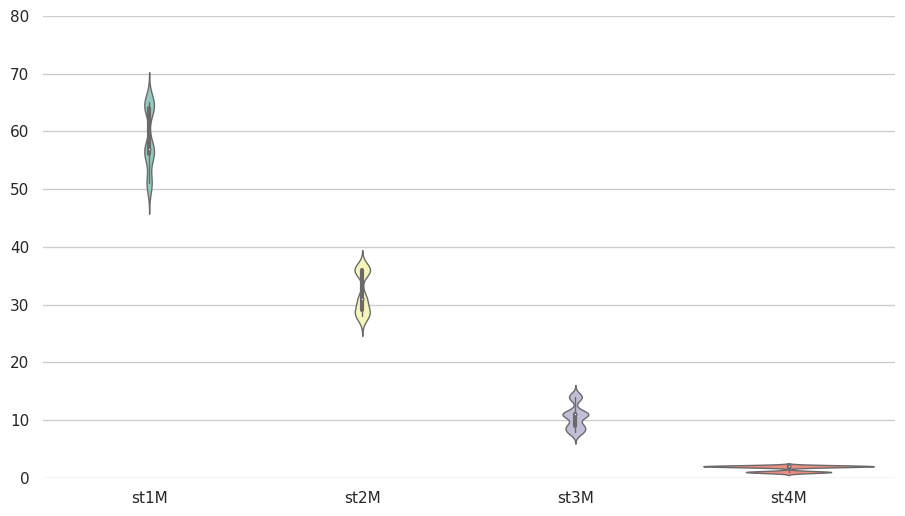

In [ ]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(11, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=M5, palette="Set3", bw=.3, cut=3, linewidth=1)

# Finalize the figure
ax.set(ylim=(0, 80))
sns.despine(left=True, bottom=True)

<Axes: >

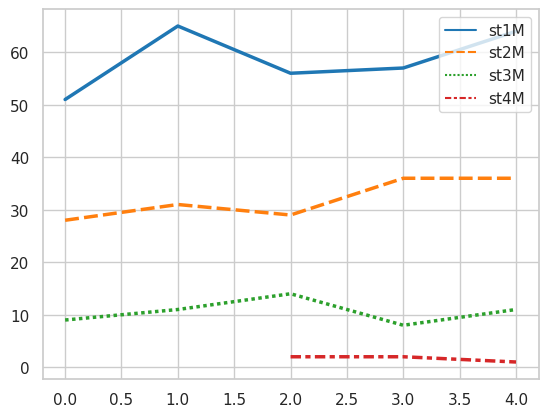

In [ ]:
sns.lineplot(data=M5, palette="tab10", linewidth=2.5)

**Динамика по неделям**

In [ ]:
step_st1W = step.groupby('Visit_W')['step1'].value_counts().to_frame (name='st1W'). reset_index()
step_st2W = step.groupby('Reg_W')['step2'].value_counts().to_frame (name='st2W'). reset_index()
step_st3W = step.groupby('App_W')['step3'].value_counts().to_frame (name='st3W'). reset_index()
step_st4W = step.groupby('Game_W')['step4'].value_counts().to_frame (name='st4W'). reset_index()

In [ ]:
step_st2W.head()

,Reg_W,step2,st2W
0,2022-35,reg,1
1,2022-36,reg,6
2,2022-37,reg,8
3,2022-38,reg,7
4,2022-39,reg,10


In [ ]:
W1=step_st1W.merge(step_st2W, left_on='Visit_W', right_on ='Reg_W', how='left')
W2=W1.merge(step_st3W, left_on='Reg_W', right_on ='App_W', how='left')
W3=W2.merge(step_st4W, left_on='App_W', right_on ='Game_W', how='left')


In [ ]:
W3.head()

,Visit_W,step1,st1W,Reg_W,step2,st2W,App_W,step3,st3W,Game_W,step4,st4W
0,2022-35,visit,7,2022-35,reg,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-36,visit,6,2022-36,reg,6,2022-36,app,3.0,NaN,NaN,NaN
2,2022-37,visit,16,2022-37,reg,8,2022-37,app,3.0,NaN,NaN,NaN
3,2022-38,visit,12,2022-38,reg,7,2022-38,app,2.0,NaN,NaN,NaN
4,2022-39,visit,17,2022-39,reg,10,2022-39,app,1.0,NaN,NaN,NaN


In [ ]:
W4 = W3.drop(columns=['step1','step2','step3', 'step4', 'Reg_W','App_W','Game_W' ])

W4.rename(columns={'Visit_W': 'Step_per_Weeks'}, inplace=True)
W4.head()

,Step_per_Weeks,st1W,st2W,st3W,st4W
0,2022-35,7,1,NaN,NaN
1,2022-36,6,6,3.0,NaN
2,2022-37,16,8,3.0,NaN
3,2022-38,12,7,2.0,NaN
4,2022-39,17,10,1.0,NaN


In [ ]:
s1=W4.loc[:,'st1W'].tolist()
s2=W4.loc[:,'st2W'].tolist()
s3=W4.loc[:,'st3W'].tolist()
s4=W4.loc[:,'st4W'].tolist()
s5=W4.loc[:,'Step_per_Weeks'].tolist()
print(s1)
print(s2)
print(s3)
print(s4)
print(s5)

[7, 6, 16, 12, 17, 18, 13, 12, 15, 16, 12, 7, 14, 12, 15, 14, 16, 7, 19, 14, 13, 13, 5]
[1, 6, 8, 7, 10, 7, 6, 6, 8, 9, 8, 3, 9, 5, 9, 6, 9, 7, 8, 9, 7, 10, 2]
[nan, 3.0, 3.0, 2.0, 1.0, 7.0, 1.0, 1.0, 2.0, 4.0, 5.0, 2.0, 2.0, 1.0, 1.0, 1.0, 3.0, 3.0, 2.0, 3.0, 1.0, 4.0, 1.0]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.0, nan, 1.0, nan, nan, 1.0, nan, nan, 1.0, nan, 1.0, nan, nan, nan]
['2022-35', '2022-36', '2022-37', '2022-38', '2022-39', '2022-40', '2022-41', '2022-42', '2022-43', '2022-44', '2022-45', '2022-46', '2022-47', '2022-48', '2022-49', '2022-50', '2022-51', '2022-52', '2023-1', '2023-2', '2023-3', '2023-4', '2023-5']


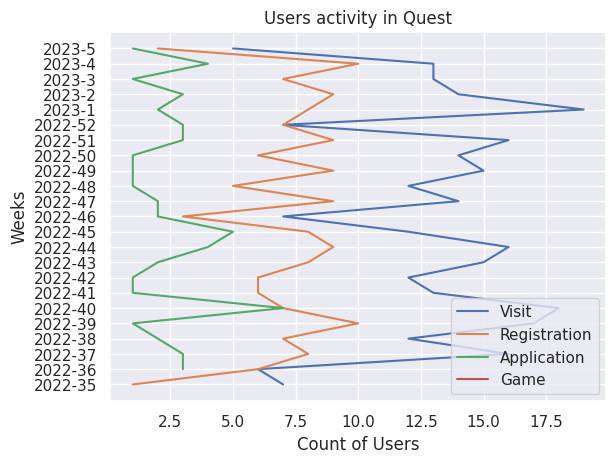

In [ ]:
columns = W4[['st1W', 	'st2W' ,	'st3W', 	'st4W']]
x=columns
y= W4['Step_per_Weeks']
plt.plot(x, y)

plt.xlabel("Count of Users")

plt.ylabel("Weeks")
plt.legend(['Visit', 'Registration', 'Application', 'Game'], loc ="lower right")
plt.title("Users activity in Quest")

plt.show()  # show first chart




In [ ]:
W4.head()

,Step_per_Weeks,st1W,st2W,st3W,st4W
0,2022-35,7,1,NaN,NaN
1,2022-36,6,6,3.0,NaN
2,2022-37,16,8,3.0,NaN
3,2022-38,12,7,2.0,NaN
4,2022-39,17,10,1.0,NaN


In [ ]:
#q1=W4.iloc[0].tolist()
#q2=W4.iloc[1].tolist()
#q3=W4.iloc[2].tolist()
#q4=W4.iloc[3].tolist()
#q5=W4.iloc[4].tolist()
# Делаю срезы по всем строкам.

In [ ]:
from plotly import graph_objects as go

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '2022-35',
    y = ["Visit", "Registration", "Application", "Game"],
    x = [7,1,0, 0],
    textinfo = "value+percent initial",
     marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-36',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [6, 6, 3, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-37',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [16, 8, 3.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))


fig.add_trace(go.Funnel(
    name = '2022-38',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [12, 7, 2.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-39',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [17, 10, 1.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-40',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [18, 7, 7.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
   marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-41',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [ 13, 6, 1.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-42',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [12, 6, 1.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-43',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [15, 8, 2.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))


fig.add_trace(go.Funnel(
    name = '2022-44',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [16, 9, 4.0, 1.0],
    textposition = "inside",
    textinfo = "value+percent previous",
   marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-45',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [12, 8, 5.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-46',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [7, 3, 2.0, 1.0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-47',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [14, 9, 2.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-48',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [12, 5, 1.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-49',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [15, 9, 1.0, 1.0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-50',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [14, 6, 1.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
   marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-51',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [16, 9, 3.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2022-52',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [7, 7, 3.0, 1.0],
    textposition = "inside",
    textinfo = "value+percent previous",
   marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2023-1',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [19, 8, 2.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2023-2',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [14, 9, 3.0, 1.0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2023-3',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [13, 7, 1.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2023-4',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [13, 10, 4.0, 0],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.add_trace(go.Funnel(
    name = '2023-5',
    orientation = "h",
    y = ["Visit", "Registration", "Application", "Game"],
    x = [  5, 2, 1.0, 0],
    textposition = "outside",
    textinfo = "value+percent total",
    marker = {"color": ["azure","lightgreen", 'lightseagreen', 'cadetblue', 'lightslategrey']}))

fig.show()

In [ ]:
W5 = W4.loc[:, ['st1W',	'st2W',	'st3W',	'st4W']]

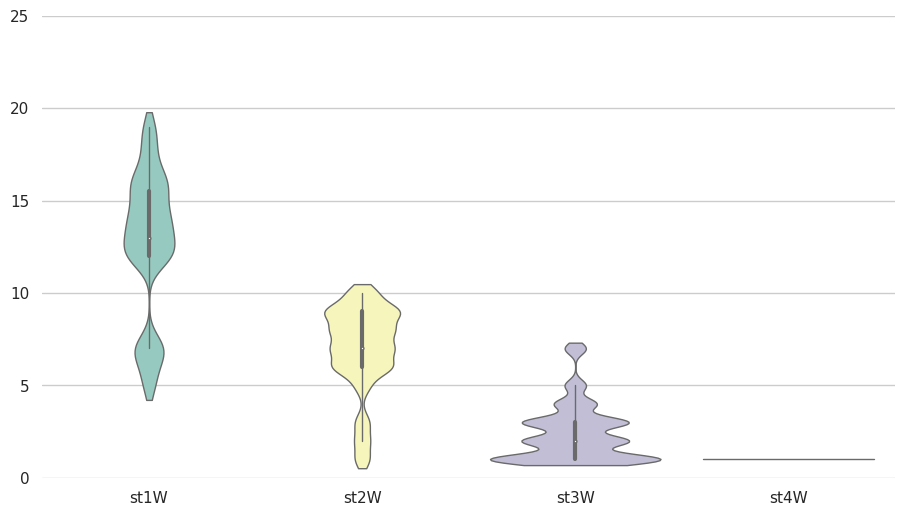

In [ ]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(11, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=W5, palette="Set3", bw=.2, cut=1, linewidth=1)

# Finalize the figure
ax.set(ylim=(0, 25))
sns.despine(left=True, bottom=True)

<Axes: >

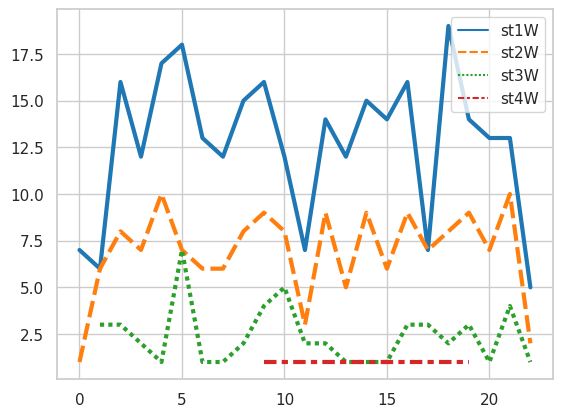

In [ ]:
sns.lineplot(data=W5, palette="tab10", linewidth=3)

На графике видно, что люди интересуются квестом постоянно, хоть и с разной степенью активности. Есть ярко выраженные спады посещений на 11 и 17 неделях проекта.
11 неделя отмечена ещё и снижением количества регистраций.
Также наблюдается рост числа регистраций на 5 неделе проекта.
В разрезе недель наблюдается всплеск активности на 38-41 неделе 2022г (4-7 неделя проекта).
Участники, зарегистировавшиеся на последних неделях проекта не добрались до квеста.

**Выводы:**



1.   Квест интересен пользователям на всем протяжении проекта
2.   Наблюдается всплеск активности( посещений - регистаций- заявок на участие) на 5й неделе проекта.
3.   Максимум посещений зафиксировано 18 неделе. Минимум посещений приходится на вторую неделю проекта.
4.   Наибольшее количество регистраций было сделано на 21 неделе. Наименьшее - на 11 неделе.
5.   Количество принятых заявок на участие достигло максимума на 5 неделе.
6.   На 9 неделе проекта наблюдается спад пользовательской активности.
7.   В квест играли с 9 по 18 неделю.
8.   В разрезе месяцев интерес к квесту можно назвать стабильным.


